In [1]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.util.remote import Remote

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling,IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import math
import copy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout

In [2]:
# Criptomoedas que vamos escolher para nosso portifólio
cryptos = [
    'BTC-USD', 'ETH-USD','LTC-USD', 'ADA-USD',
    'DOT-USD', 'LINK-USD','SOL-USD',
    'TRX-USD'
]

In [3]:
data_visual = {}
for crypto in cryptos:
    data_visual[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')
    data_visual[crypto] = data_visual[crypto][~data_visual[crypto].index.duplicated(keep='first')]

In [4]:
data_visual['BTC-USD'].dropna()

,Crypto_Return_Today,exp_value
Date,,
2021-04-09,-0.001399,0.002879
2021-04-10,0.026084,0.004583
2021-04-11,0.005976,0.002280
2021-04-12,-0.004705,0.005169
2021-04-13,0.058584,0.004793
...,...,...
2024-10-16,0.008470,0.003743
2024-10-17,-0.003218,-0.000829
2024-10-18,0.014719,0.006106


0.008 representa o 5% maiores valores de exp_value preditos

In [136]:
for crypto in cryptos:
    df = data_visual[crypto]
    df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
    df['ae'] = abs(df['ae'])
    df = df.dropna()
    num_positive = (df['Crypto_Return_Today'] > 0).sum()
    num_negative = (df['Crypto_Return_Today'] < 0).sum()

    hat_pos = (df['exp_value'] > 0).sum()
    hat_neg = (df['exp_value'] < 0).sum()


    TP = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] > 0)).sum()
    TN = ((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] < 0)).sum()
    FP = ((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] > 0)).sum()
    FN = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] < 0)).sum()

    #rmse = np.sqrt(((df['Crypto_Return_Today'] - df['exp_value']) ** 2).mean())
    print("\n\n--------------------------------------------------------")
    print("\n\nCriptomoeda: ", crypto)
    print("\n                              Real")
    print("\nNumero de Subidas: ",num_positive,"   |   ",100*num_positive / (num_negative + num_positive),"%")
    print("\nNumero de Quedas : ",num_negative,"   |   ",100*num_negative / (num_negative + num_positive),"%")

    print("\n                              Predito")
    print("\nNumero de Subidas: ",hat_pos,"   |   ", 100*hat_pos / (hat_neg + hat_pos),"%")
    print("\nNumero de Quedas : ",hat_neg,"   |   ", 100*hat_neg / (hat_neg + hat_pos),"%")

    print("\nMean Absolute Error MAE: ", df['ae'].mean())
    #print("\nRoot Mean Squared Error RMSE: ", rmse)
    print("\nAcc: ", (TP+TN) / (TP + FP + FN + FP))
    print("\nSen: ", (TP) / (TP + FN)) # significa, entre os que subiram, quantos % eu consegui identificar que realmente subiu
    print("\nSpe: ", (TP) / (TP + FN)) # significa, entre os que cairam, quantos % eu consegui identificar que realmente caiu
    print("\nPre: ", (TP) / (TP + FP)) # significa, entre os que eu disse que ia subir, quantos % realmente subiram

    TP = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] > 0) & (df['exp_value'] >= 0.008)).sum()
    FP = (((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] > 0)) & (df['exp_value'] >= 0.008)).sum()

    limite_90 = df['exp_value'].quantile(0.9)
    menor_valor_10_maiores = df[df['exp_value'] >= limite_90]['exp_value'].min()
    print("\nLower bound dos 10% maiores: ", menor_valor_10_maiores)
    print("\nPrecisao para maiores que 0.008: ", (TP) / (TP + FP)) # significa, entre os que eu disse que ia subir, quantos % realmente subiram



--------------------------------------------------------


Criptomoeda:  BTC-USD

                              Real

Numero de Subidas:  660    |    49.549549549549546 %

Numero de Quedas :  672    |    50.450450450450454 %

                              Predito

Numero de Subidas:  714    |    53.6036036036036 %

Numero de Quedas :  618    |    46.3963963963964 %

Mean Absolute Error MAE:  0.022329113998209287

Acc:  0.49343065693430654

Sen:  0.543939393939394

Spe:  0.543939393939394

Pre:  0.5028011204481793

Lower bound dos 10% maiores:  0.0070394938811659

Precisao para maiores que 0.008:  0.5257731958762887


--------------------------------------------------------


Criptomoeda:  ETH-USD

                              Real

Numero de Subidas:  678    |    50.9009009009009 %

Numero de Quedas :  654    |    49.0990990990991 %

                              Predito

Numero de Subidas:  722    |    54.2042042042042 %

Numero de Quedas :  610    |    45.7957957957958 %

Mean Abs



--------------------------------------------------------


Criptomoeda:  BTC-USD

                              Real

Numero de Subidas:  655    |    49.50869236583522 %

Numero de Quedas :  668    |    50.49130763416478 %

                              Predito

Numero de Subidas:  709    |    53.59032501889645 %

Numero de Quedas :  614    |    46.40967498110355 %

Mean Absolute Error MAE:  0.02225602819386449

Acc:  0.4952170713760118

Sen:  0.5450381679389313

Spe:  0.5450381679389313

Pre:  0.5035260930888575

Lower bound dos 10% maiores:  0.0070394938811659

Precisao para maiores que 0.008:  0.5208333333333334


--------------------------------------------------------


Criptomoeda:  ETH-USD

                              Real

Numero de Subidas:  674    |    50.944822373393805 %

Numero de Quedas :  649    |    49.055177626606195 %

                              Predito

Numero de Subidas:  714    |    53.96825396825397 %

Numero de Quedas :  609    |    46.03174603174603 %

Mean Absolute Error MAE:  0.02821748020721412

Acc:  0.4955947136563877

Sen:  0.5489614243323442

Spe:  0.5489614243323442

Pre:  0.5182072829131653

Lower bound dos 10% maiores:  0.0086960233747959

Precisao para maiores que 0.008:  0.5424836601307189


--------------------------------------------------------


Criptomoeda:  LTC-USD

                              Real

Numero de Subidas:  675    |    51.02040816326531 %

Numero de Quedas :  648    |    48.97959183673469 %

                              Predito

Numero de Subidas:  609    |    46.03174603174603 %

Numero de Quedas :  714    |    53.96825396825397 %

Mean Absolute Error MAE:  0.0309698264594453

Acc:  0.5058456742010912

Sen:  0.45185185185185184

Spe:  0.45185185185185184

Pre:  0.5008210180623974

Lower bound dos 10% maiores:  0.0073726628907024

Precisao para maiores que 0.008:  0.45132743362831856


--------------------------------------------------------


Criptomoeda:  ADA-USD

                              Real

Numero de Subidas:  651    |    49.24357034795764 %

Numero de Quedas :  671    |    50.75642965204236 %

                              Predito

Numero de Subidas:  560    |    42.32804232804233 %

Numero de Quedas :  763    |    57.67195767195767 %

Mean Absolute Error MAE:  0.032366329233653054

Acc:  0.5935647756138865

Sen:  0.45314900153609833

Spe:  0.45314900153609833

Pre:  0.5267857142857143

Lower bound dos 10% maiores:  0.0110120354220271

Precisao para maiores que 0.008:  0.5473684210526316


--------------------------------------------------------


Criptomoeda:  DOT-USD

                              Real

Numero de Subidas:  660    |    49.88662131519274 %

Numero de Quedas :  663    |    50.11337868480726 %

                              Predito

Numero de Subidas:  546    |    41.26984126984127 %

Numero de Quedas :  777    |    58.73015873015873 %

Mean Absolute Error MAE:  0.03481772583324544

Acc:  0.5838983050847457

Sen:  0.43333333333333335

Spe:  0.43333333333333335

Pre:  0.5238095238095238

Lower bound dos 10% maiores:  0.0103750182315707

Precisao para maiores que 0.008:  0.4797687861271676


--------------------------------------------------------


Criptomoeda:  LINK-USD

                              Real

Numero de Subidas:  684    |    51.70068027210884 %

Numero de Quedas :  639    |    48.29931972789116 %

                              Predito

Numero de Subidas:  614    |    46.40967498110355 %

Numero de Quedas :  709    |    53.59032501889645 %

Mean Absolute Error MAE:  0.03720316257319208

Acc:  0.5038819875776398

Sen:  0.45614035087719296

Spe:  0.45614035087719296

Pre:  0.50814332247557

Lower bound dos 10% maiores:  0.0091520426794886

Precisao para maiores que 0.008:  0.5257142857142857


--------------------------------------------------------


Criptomoeda:  SOL-USD

                              Real

Numero de Subidas:  659    |    49.81103552532124 %

Numero de Quedas :  664    |    50.18896447467876 %

                              Predito

Numero de Subidas:  731    |    55.253212396069536 %

Numero de Quedas :  592    |    44.746787603930464 %

Mean Absolute Error MAE:  0.04272589616417883

Acc:  0.5203552923760177

Sen:  0.5842185128983308

Spe:  0.5842185128983308

Pre:  0.5266757865937073

Lower bound dos 10% maiores:  0.0195541474968194

Precisao para maiores que 0.008:  0.543010752688172


--------------------------------------------------------


Criptomoeda:  TRX-USD

                              Real

Numero de Subidas:  714    |    53.96825396825397 %

Numero de Quedas :  609    |    46.03174603174603 %

                              Predito

Numero de Subidas:  803    |    60.69538926681784 %

Numero de Quedas :  520    |    39.30461073318216 %

Mean Absolute Error MAE:  0.023709942762740625

Acc:  0.4702627939142462

Sen:  0.6120448179271709

Spe:  0.6120448179271709

Pre:  0.5442092154420921

Lower bound dos 10% maiores:  0.0074163237586617

Precisao para maiores que 0.008:  0.5630252100840336

In [129]:
df = data_visual['ETH-USD']
df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
df['ae'] = abs(df['ae'])

In [130]:
df['mae'] = df['ae'].rolling(window = 50).mean()

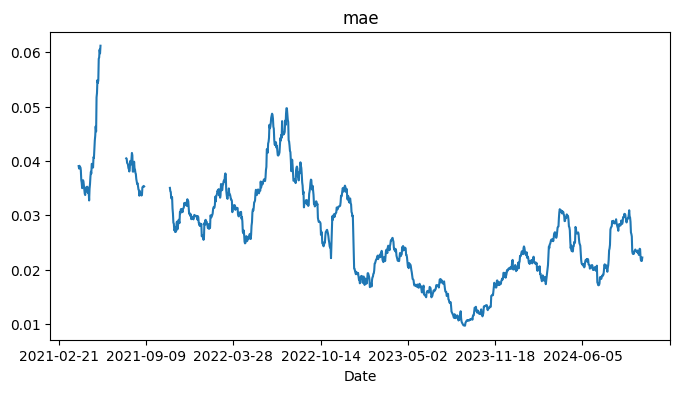

In [131]:
from matplotlib import pyplot as plt
df['mae'].plot(kind='line', figsize=(8, 4), title='mae')
plt.gca().spines[['top', 'right']].set_visible(True)

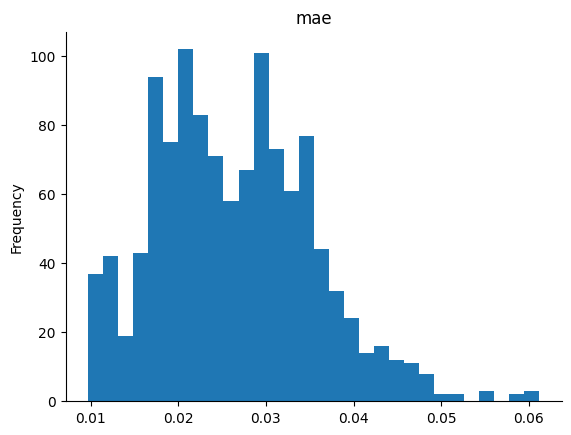

In [76]:
from matplotlib import pyplot as plt
df['mae'].plot(kind='hist', bins=30, title='mae')
plt.gca().spines[['top', 'right',]].set_visible(False)

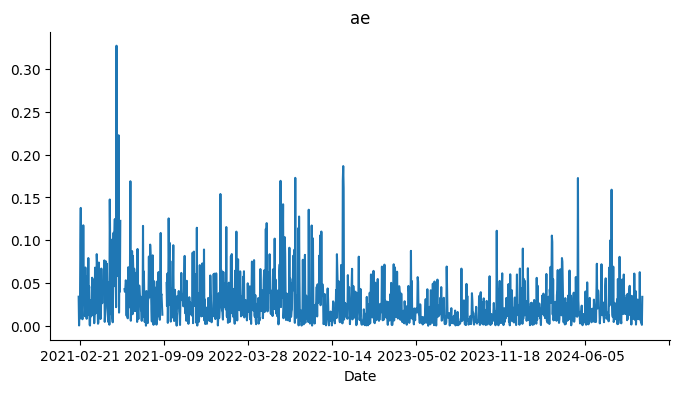

In [77]:
from matplotlib import pyplot as plt
df['ae'].plot(kind='line', figsize=(8, 4), title='ae')
plt.gca().spines[['top', 'right']].set_visible(False)

### **Vamos criar data2**
#### Este será um dicionário que lê os csv's salvos e os armazena para cada criptomoeda

In [78]:
data2 = {}
for crypto in cryptos:
    data2[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')
    data2[crypto] = data2[crypto][~data2[crypto].index.duplicated(keep='first')]
    #data_complete[crypto] = pd.read_csv(f"{crypto}.csv")

In [79]:
for crypto in cryptos:
    print(len(data2[crypto]))
    data2[crypto] = data2[crypto]


2983
2538
2983
2538
1523
2538
1655
2538


In [80]:
data2['BTC-USD']

,Crypto_Return_Today,exp_value
Date,,
2016-08-21,-0.001085,NaN
2016-08-22,0.009318,NaN
2016-08-23,-0.005736,NaN
2016-08-24,-0.005552,NaN
2016-08-25,-0.004178,NaN
...,...,...
2024-10-16,0.008470,0.003743
2024-10-17,-0.003218,-0.000829
2024-10-18,0.014719,0.006106


### **Vamos criar data_mus**
#### Este será um DataFrame que cada linha representa uma sample, e cada coluna representa o valor esperado de um dos ativos de nosso portifólio.

In [81]:
data_mus = pd.DataFrame()
for crypto in cryptos:
    data_mus = pd.merge(data_mus, data2[crypto]['exp_value'], left_index=True, right_index=True, how='outer', suffixes=('', crypto))
    data_mus = data_mus.rename(columns={f'exp_value{crypto}': crypto})

In [82]:
#data_mus.fillna(0, inplace=True)
data_mus = data_mus.rename(columns={'exp_value': 'BTC-USD'})
data_mus

,BTC-USD,ETH-USD,LTC-USD,ADA-USD,DOT-USD,LINK-USD,SOL-USD,TRX-USD
Date,,,,,,,,
2016-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-10-16,0.003743,0.009319,0.009478,0.000991,0.002552,0.002543,0.005475,0.004135
2024-10-17,-0.000829,0.001030,-0.003648,0.000392,0.000020,-0.000362,0.002275,0.001567
2024-10-18,0.006106,0.000691,0.003061,0.002838,0.004308,0.003416,0.000949,0.001356


### **Vamos criar data_reals**
#### Este será um DataFrame que cada linha representa uma sample, e cada coluna representa o valor real de um dos ativos de nosso portifólio.

In [83]:
data_reals = pd.DataFrame()
for crypto in cryptos:
    data_reals = pd.merge(data_reals, data2[crypto]['Crypto_Return_Today'], left_index=True, right_index=True, how='outer', suffixes=('', crypto))
    data_reals = data_reals.rename(columns={f'Crypto_Return_Today{crypto}': crypto})

In [84]:
data_reals = data_reals.rename(columns={'Crypto_Return_Today': 'BTC-USD'})
data_reals

,BTC-USD,ETH-USD,LTC-USD,ADA-USD,DOT-USD,LINK-USD,SOL-USD,TRX-USD
Date,,,,,,,,
2016-08-21,-0.001085,NaN,-0.001200,NaN,NaN,NaN,NaN,NaN
2016-08-22,0.009318,NaN,0.010953,NaN,NaN,NaN,NaN,NaN
2016-08-23,-0.005736,NaN,0.070155,NaN,NaN,NaN,NaN,NaN
2016-08-24,-0.005552,NaN,-0.018953,NaN,NaN,NaN,NaN,NaN
2016-08-25,-0.004178,NaN,-0.014212,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-10-16,0.008470,0.001948,-0.011386,-0.016882,-0.019825,-0.017466,-0.003149,0.007900
2024-10-17,-0.003218,-0.002653,0.037386,-0.027303,-0.030039,-0.019495,-0.025758,-0.004309
2024-10-18,0.014719,0.014005,0.005285,0.022151,0.027627,0.040463,0.030485,-0.005173


### **Vamos criar  mus e reals e covs**
#### mus será um dicionário, cujas chaves são as datas que compõe o index de data_mus, e cada item é um numpy array de 8 elementos (representando as criptomoedas) e 1 ultimo elemento representando o RFR
#### reals será um dicionário cujas chaves são as datas que compõe do index de data_mus, e cada item é um np array de 8 elementos (representando as criptomoedas) e 1 ultimo elemento representando o RFR
##### *Importante!* - Vamos fazer de tal modo que, para os arrays com valores NaN, nós removemos ele do portifólio

In [85]:
covs = {}
mus = {}
reals = {}

for i in range(100, data_mus.shape[0], 1):
    if(i < 200):
        df1 = data_reals[0:i] # Tabela que vai me ajudar a criar a matriz de covariância
        df2 = data_mus[i:i+1] # de onde vou coletar o previsto
        df3 = data_reals[i:i+1] # de onde vou coletar o real
    else:
        df1 = data_reals[i-200:i] # Tabela que vai me ajudar a criar a matriz de covariância
        df2 = data_mus[i:i+1]
        df3 = data_reals[i:i+1] # de onde vou coletar o real
        
    cols_with_nan_in_df2 = df2.isna().any()
    # Remover do df1 as colunas que possuem NaN em df2
    df1_cleaned = df1.drop(columns=df1.columns[cols_with_nan_in_df2])
    df2_cleaned = df2.dropna(axis=1)
    df3_cleaned = df3.drop(columns=df1.columns[cols_with_nan_in_df2])
    # Remover do df2 as colunas que possuem 60% NaN em df1
    percent_nan_df1 = df1_cleaned.isna().mean()
    cols_to_drop = percent_nan_df1[percent_nan_df1 >= 0.6].index
    df1_cleaned = df1_cleaned.drop(columns=cols_to_drop, errors='ignore')
    df2_cleaned = df2_cleaned.drop(columns=cols_to_drop, errors='ignore')
    df3_cleaned = df3_cleaned.drop(columns=cols_to_drop, errors='ignore')

    date = data_mus.index[i]
    covs[date] = df1_cleaned.cov()
    mus[date] = df2_cleaned
    reals[date] = df3_cleaned


covs[date]
mus[date]
reals[date]


São todos dataframes

pra retirar o valor de mus e reals basta fazer um .to_numpy().flatten()

In [86]:
"""covs = {}
for i in range(100, data_mus.shape[0], 1):
    df = pd.DataFrame()
    if(i < 200):
        df = data_reals_with_RFR.iloc[0: i].dropna(axis = 1)
    else:
        df = data_reals_with_RFR.iloc[i-200: i].dropna(axis = 1)
    date = data_reals_with_RFR.index[i]

    covs[date] = df.cov().to_numpy()"""

'covs = {}\nfor i in range(100, data_mus.shape[0], 1):\n    df = pd.DataFrame()\n    if(i < 200):\n        df = data_reals_with_RFR.iloc[0: i].dropna(axis = 1)\n    else:\n        df = data_reals_with_RFR.iloc[i-200: i].dropna(axis = 1)\n    date = data_reals_with_RFR.index[i]\n\n    covs[date] = df.cov().to_numpy()'

In [87]:
"""reals = {}
mus = {}

for i in range(100, data_mus.shape[0], 1):
    date = data_reals_with_RFR.index[i]
    
    for crypto in cryptos:
        if date in data2[crypto].index:
            if data2[crypto].
            reals[date] = np.append(reals[date], 1)"""

'reals = {}\nmus = {}\n\nfor i in range(100, data_mus.shape[0], 1):\n    date = data_reals_with_RFR.index[i]\n    \n    for crypto in cryptos:\n        if date in data2[crypto].index:\n            if data2[crypto].\n            reals[date] = np.append(reals[date], 1)'

In [88]:
"""reals = {}
mus = {} # mus[date] será um numpy array de K elementos
for i in range(data_mus.shape[0]):
    date = data_mus.index[i]

    mus[date] = data_mus.iloc[i].to_numpy()
    reals[date] = data_reals.iloc[i].to_numpy()

    
    reals[date] = reals[date][~np.isnan(mus[date])]
    mus[date] = mus[date][~np.isnan(mus[date])]

    mus[date] = np.exp(mus[date]) - 1
    reals[date] = np.exp(reals[date]) - 1

    reals[date] = np.append(reals[date], 0.00031)
    mus[date] = np.append(mus[date], 0.00031)"""

'reals = {}\nmus = {} # mus[date] será um numpy array de K elementos\nfor i in range(data_mus.shape[0]):\n    date = data_mus.index[i]\n\n    mus[date] = data_mus.iloc[i].to_numpy()\n    reals[date] = data_reals.iloc[i].to_numpy()\n\n    \n    reals[date] = reals[date][~np.isnan(mus[date])]\n    mus[date] = mus[date][~np.isnan(mus[date])]\n\n    mus[date] = np.exp(mus[date]) - 1\n    reals[date] = np.exp(reals[date]) - 1\n\n    reals[date] = np.append(reals[date], 0.00031)\n    mus[date] = np.append(mus[date], 0.00031)'

In [89]:
"""reals = {} # mus[date] será um numpy array de 8 elementos
for i in range(data_reals.shape[0]):
    date = data_reals.index[i]
    reals[date] = data_reals.iloc[i].to_numpy()
    reals[date] = reals[date][~np.isnan(reals[date])]
    reals[date] = np.append(reals[date], 0.002)"""

'reals = {} # mus[date] será um numpy array de 8 elementos\nfor i in range(data_reals.shape[0]):\n    date = data_reals.index[i]\n    reals[date] = data_reals.iloc[i].to_numpy()\n    reals[date] = reals[date][~np.isnan(reals[date])]\n    reals[date] = np.append(reals[date], 0.002)'

em cada dia: date

covs[date] é a matriz de covariancia


mus[date] é o vetor de valores preditos


reals[date] é o vetor de valores reais


isso gera um portifólio ws[date]


para esse portifólio, vamos ter como retorno percentual ws[date]*(e^mus[date] - 1) que vamos armazenar em profit[date]

In [90]:
from pymoo.core.problem import ElementwiseProblem

class PortfolioProblemGA(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate=0, **kwargs):
        # Problema com apenas 1 objetivo. Minimizar a função objetivo _evaluate que é sharpe * -1
        super().__init__(n_var=len(mu), n_obj=1, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu # @ é multiplicação de matriz 
        exp_risk = np.sqrt(x.T @ self.cov @ x) 
        if exp_risk <= 0.00001:
            sharpe = 0
        else:
            sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = -sharpe #[exp_risk, -exp_return]
        # importante : Note o sinal negativo para Sharpe (queremos maximizar Sharpe), mas o pymoo esperar minimizar
        # 
        out["risk_return"] = [exp_risk, -exp_return]


from pymoo.core.repair import Repair

class PortfolioRepair(Repair): # Elimina pesos muito baixos (menores que 0.001)
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0 # Seta valores menores que 0.001 (1e-3) para zero
        X=X / X.sum(axis=1, keepdims=True) # normaliza o portfolio (somatorio dos pesos igual a 1) 
        return X

In [91]:
import os
def Portfolio(mu, cov, day):
    # Solução com GA
    problem = PortfolioProblemGA(mu, cov)


    algorithm = GA(
        pop_size=100,
        crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()), # Simulated Binary Crossover, hyperparameters: prob of crossover, eta - parameter of crossover distribution
        mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()),  
        eliminate_duplicates=True)

    res = minimize(problem, # observe que estamos minimizando
                algorithm,
                termination=('n_gen', 1000),# Criterio de termino: numero de geracoes!
                seed=1,
                verbose=False)
    
    # Apresentação dos Resultados
    #res.X: Design space values are
    #res.F: Objective spaces values

    X, F, sharpe = res.opt.get("X", "risk_return", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()

    plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
    plt.scatter(cov.diagonal() ** 0.5, mu, facecolor="none", edgecolors="black", s=30, label="Asset")
    plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
    plt.legend()
    plt.xlabel("expected volatility")
    plt.ylabel("expected return")
    plt.savefig(os.path.join(save_directory, f'portfolio_plot_{day}.png'), bbox_inches='tight')
    plt.close()  # Fecha a figura para liberar memória
    import operator

    allocation = {name: w for name, w in zip(cryptos, X[max_sharpe])}

    X, F, sharpe = res.opt.get("X", "risk_return", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()
    
    allocation = {name: w for name, w in zip(cryptos, X[max_sharpe])}

    pesos = []
    for name, w in allocation.items():
        pesos = np.append(pesos, w)
    return pesos


In [92]:
# Define o caminho para salvar as imagens
global save_directory 
save_directory = "C:\\Users\\delve\OneDrive\\Eu\\GitHub\\Quantamental\\Código\\Plots"  # Altere para o caminho desejado
os.makedirs(save_directory, exist_ok=True)  # Cria a pasta se não existir


### Pesos sera um dicionário que vai armazenar os pesos que devo distribuir nas ações na determinada data: date

In [93]:
pesos = {}

In [99]:
date = data_mus.index[1941]
date

'2021-12-14'

In [94]:
data_mus.dropna()

,BTC-USD,ETH-USD,LTC-USD,ADA-USD,DOT-USD,LINK-USD,SOL-USD,TRX-USD
Date,,,,,,,,
2021-02-18,0.007994,0.013200,0.019519,0.025651,0.036377,0.009201,0.036008,0.012042
2021-02-19,0.015481,0.011246,0.012032,0.017751,0.023632,0.013307,0.026382,0.010798
2021-02-20,0.018290,0.006841,0.014415,0.025461,0.025560,0.013163,0.051830,0.007791
2021-02-21,0.015050,0.017114,0.017543,0.023656,0.035045,0.012016,0.013948,0.008129
2021-02-22,0.009703,0.010770,0.015118,0.042512,0.009928,0.013837,0.028314,0.011882
...,...,...,...,...,...,...,...,...
2024-10-16,0.003743,0.009319,0.009478,0.000991,0.002552,0.002543,0.005475,0.004135
2024-10-17,-0.000829,0.001030,-0.003648,0.000392,0.000020,-0.000362,0.002275,0.001567
2024-10-18,0.006106,0.000691,0.003061,0.002838,0.004308,0.003416,0.000949,0.001356


In [101]:
for i in range(1900, 1941, 1):
    date = data_mus.index[i]
    pesos[date] = Portfolio(mus[date].to_numpy().flatten(), covs[date].to_numpy(), i)
    print("Etapa ", i, " de ", 2241)

Etapa  1900  de  2241
Etapa  1901  de  2241
Etapa  1902  de  2241
Etapa  1903  de  2241
Etapa  1904  de  2241
Etapa  1905  de  2241
Etapa  1906  de  2241
Etapa  1907  de  2241
Etapa  1908  de  2241
Etapa  1909  de  2241
Etapa  1910  de  2241
Etapa  1911  de  2241
Etapa  1912  de  2241
Etapa  1913  de  2241
Etapa  1914  de  2241
Etapa  1915  de  2241
Etapa  1916  de  2241
Etapa  1917  de  2241
Etapa  1918  de  2241
Etapa  1919  de  2241
Etapa  1920  de  2241
Etapa  1921  de  2241
Etapa  1922  de  2241
Etapa  1923  de  2241
Etapa  1924  de  2241
Etapa  1925  de  2241
Etapa  1926  de  2241
Etapa  1927  de  2241
Etapa  1928  de  2241
Etapa  1929  de  2241
Etapa  1930  de  2241
Etapa  1931  de  2241
Etapa  1932  de  2241
Etapa  1933  de  2241
Etapa  1934  de  2241
Etapa  1935  de  2241
Etapa  1936  de  2241
Etapa  1937  de  2241
Etapa  1938  de  2241
Etapa  1939  de  2241
Etapa  1940  de  2241


In [102]:
i = 2090
date = data_mus.index[i]
date

'2022-05-12'

In [103]:
pesos[date]

KeyError: '2022-05-12'

In [104]:
pd.DataFrame(pesos).T.sort_index()

,0,1,2,3,4,5,6,7
2021-02-18,0.000000,0.0,0.171583,0.218892,0.369237,0.0,0.240288,0.0
2021-02-19,0.784085,0.0,0.000000,0.000000,0.075708,0.0,0.140207,0.0
2021-02-20,0.677633,0.0,0.000000,0.027102,0.000000,0.0,0.295264,0.0
2021-02-21,0.576579,0.0,0.000000,0.147197,0.276223,0.0,0.000000,0.0
2021-02-22,0.000000,0.0,0.000000,0.934355,0.000000,0.0,0.065645,0.0
...,...,...,...,...,...,...,...,...
2021-12-09,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.0
2021-12-10,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0
2021-12-11,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2021-12-12,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0


In [105]:
data_aux = pd.read_csv('pesos1.csv', index_col = 0,  parse_dates=True)
data_aux.index = pd.to_datetime(data_aux.index)
data_aux

,0,1,2,3,4,5,6,7
2021-12-14,0.0,0.000000,0.00000,0.0,0.0,0.0,1.000000,0.000000
2021-12-15,0.0,0.479949,0.00000,0.0,0.0,0.0,0.520051,0.000000
2021-12-16,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,1.000000
2021-12-17,1.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000
2021-12-18,1.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-10-16,0.0,0.416760,0.58324,0.0,0.0,0.0,0.000000,0.000000
2024-10-17,0.0,0.000000,0.00000,0.0,0.0,0.0,0.287129,0.712871
2024-10-18,1.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000
2024-10-19,1.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000


In [106]:
data_aux.columns = pd.DataFrame(pesos).T.sort_index().columns
data_aux

,0,1,2,3,4,5,6,7
2021-12-14,0.0,0.000000,0.00000,0.0,0.0,0.0,1.000000,0.000000
2021-12-15,0.0,0.479949,0.00000,0.0,0.0,0.0,0.520051,0.000000
2021-12-16,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,1.000000
2021-12-17,1.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000
2021-12-18,1.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-10-16,0.0,0.416760,0.58324,0.0,0.0,0.0,0.000000,0.000000
2024-10-17,0.0,0.000000,0.00000,0.0,0.0,0.0,0.287129,0.712871
2024-10-18,1.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000
2024-10-19,1.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000


In [107]:
pesos_concat = pd.concat([pd.DataFrame(pesos).T.sort_index(), data_aux])
pesos_concat.index = pd.to_datetime(pesos_concat.index)
pesos_concat

,0,1,2,3,4,5,6,7
2021-02-18,0.000000,0.00000,0.171583,0.218892,0.369237,0.0,0.240288,0.000000
2021-02-19,0.784085,0.00000,0.000000,0.000000,0.075708,0.0,0.140207,0.000000
2021-02-20,0.677633,0.00000,0.000000,0.027102,0.000000,0.0,0.295264,0.000000
2021-02-21,0.576579,0.00000,0.000000,0.147197,0.276223,0.0,0.000000,0.000000
2021-02-22,0.000000,0.00000,0.000000,0.934355,0.000000,0.0,0.065645,0.000000
...,...,...,...,...,...,...,...,...
2024-10-16,0.000000,0.41676,0.583240,0.000000,0.000000,0.0,0.000000,0.000000
2024-10-17,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.287129,0.712871
2024-10-18,1.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2024-10-19,1.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [108]:
pd.DataFrame(pesos_concat).sort_index().to_csv('pesos1.csv', index=True)

In [138]:
df = pd.read_csv('pesos1.csv', index_col = 0,  parse_dates=True)
df

,0,1,2,3,4,5,6,7
,,,,,,,,
2021-02-18,0.000000,0.00000,0.171583,0.218892,0.369237,0.0,0.240288,0.000000
2021-02-19,0.784085,0.00000,0.000000,0.000000,0.075708,0.0,0.140207,0.000000
2021-02-20,0.677633,0.00000,0.000000,0.027102,0.000000,0.0,0.295264,0.000000
2021-02-21,0.576579,0.00000,0.000000,0.147197,0.276223,0.0,0.000000,0.000000
2021-02-22,0.000000,0.00000,0.000000,0.934355,0.000000,0.0,0.065645,0.000000
...,...,...,...,...,...,...,...,...
2024-10-16,0.000000,0.41676,0.583240,0.000000,0.000000,0.0,0.000000,0.000000
2024-10-17,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.287129,0.712871
2024-10-18,1.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [142]:
profit = {}
for i in range(200, df.shape[0]):
    date = df.index[i].strftime('%Y-%m-%d')
    w = df.loc[date].to_numpy()
    r = np.exp(reals[date].to_numpy().flatten())
    if df.iloc[i].sum() == 1 and w @ mus[date].to_numpy().flatten() > 0.008 :
        profit[date] = w @ r
    else:
        profit[date] = 1.0002

In [143]:
df_profit = pd.DataFrame([profit], index=[0]).T
df_profit

,0
2022-02-11,1.000200
2022-02-12,1.000200
2022-02-13,1.000200
2022-02-14,1.000200
2022-02-15,1.000200
...,...
2024-10-16,0.994209
2024-10-17,1.000200
2024-10-18,1.000200
2024-10-19,0.999178


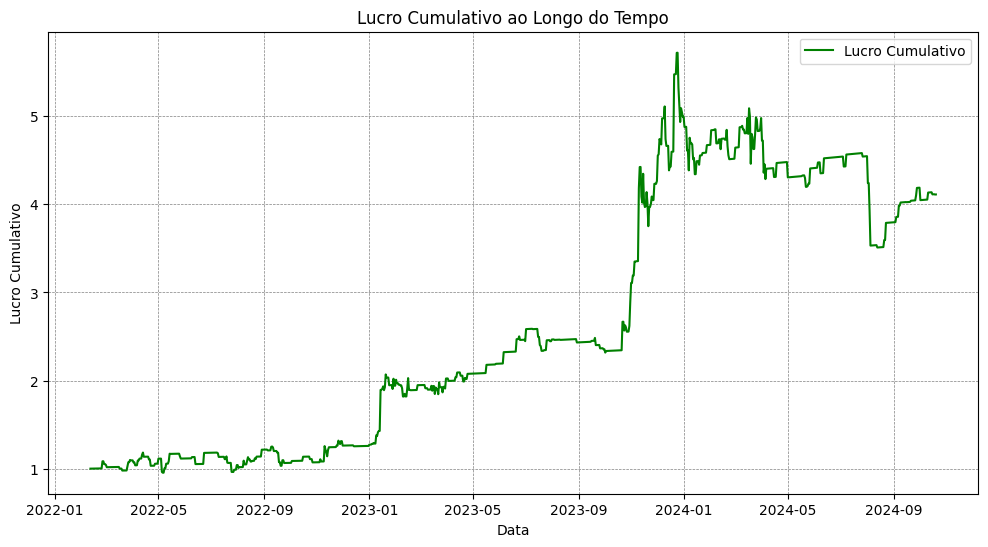

In [144]:
import matplotlib.dates as mdates
df_profit.index = pd.to_datetime(df_profit.index)
# Calcula o produto cumulativo dos valores na coluna de lucro
df_profit['cumulative_profit'] = df_profit[0].cumprod()

# Define o tamanho do gráfico (opcional)
plt.figure(figsize=(12, 6))

# Plota a série temporal do lucro cumulativo
plt.plot(df_profit.index, df_profit['cumulative_profit'], label="Lucro Cumulativo", color='green')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # Exibe uma data por mês
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Exibe no formato Ano-Mês
# Personaliza o gráfico
plt.title("Lucro Cumulativo ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Lucro Cumulativo")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')  # `which='both'` adiciona a grade principal 
#plt.savefig("lucro_cumulativo_ajustado_22-07-02_com_restricao.png", format="png", dpi=300, bbox_inches="tight")  # Salva em alta resolução com bordas ajustadas
# Exibe o gráfico
plt.show()



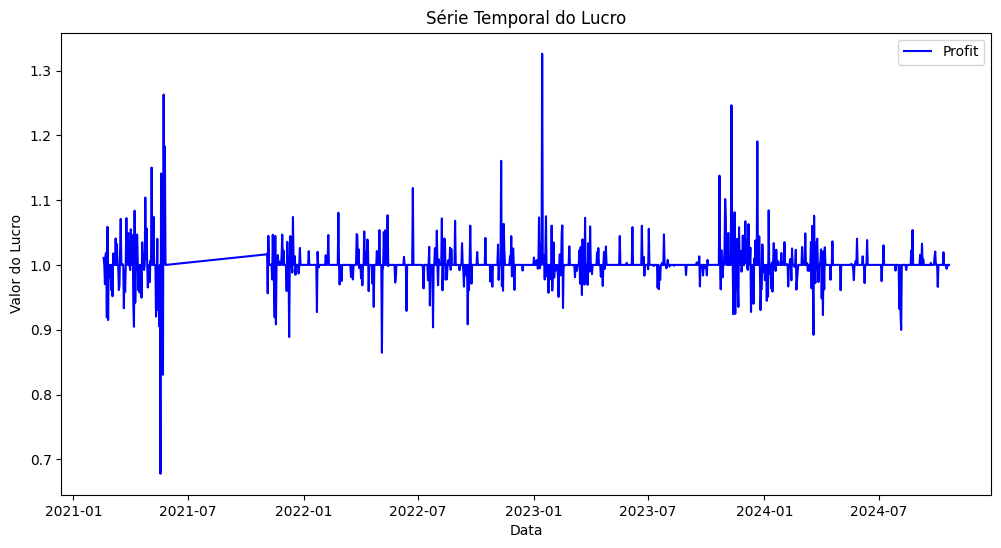

In [122]:
# Define o tamanho do gráfico (opcional)
plt.figure(figsize=(12, 6))

# Plota a série temporal
plt.plot(df_profit.index, df_profit[0], label="Profit", color='blue')

# Personaliza o gráfico
plt.title("Série Temporal do Lucro")
plt.xlabel("Data")
plt.ylabel("Valor do Lucro")
plt.legend()
#plt.savefig("lucro_serie_temporal.png", format="png", dpi=300, bbox_inches="tight")  # Salva em alta resolução com bordas ajustadas
# Exibe o gráfico
plt.show()

In [44]:
df_profit = df_profit.rename(columns={0: "profit"})

In [45]:
df_profit

,profit,cumulative_profit
2021-12-14,0.988396,0.988396
2021-12-15,1.074134,1.061670
2021-12-16,1.000300,1.061989
2021-12-17,1.000300,1.062308
2021-12-18,1.013620,1.076777
...,...,...
2024-10-16,0.994209,4.929059
2024-10-17,1.000300,4.930538
2024-10-18,1.000300,4.932017
2024-10-19,0.999178,4.927963


In [46]:
df_profit.to_csv("df_profit_1.csv")